##Setup
We'll need the Transformers library by Hugging Face:

In [ ]:
#!pip install -qq transformers
!pip install transformers==2.8.0

     |████████████████████████████████| 563 kB 9.9 MB/s 
     |████████████████████████████████| 5.6 MB 46.6 MB/s 
     |████████████████████████████████| 1.2 MB 42.7 MB/s 
     |████████████████████████████████| 895 kB 38.4 MB/s 
     |████████████████████████████████| 131 kB 50.8 MB/s 
     |████████████████████████████████| 8.0 MB 34.1 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 138 kB 66.1 MB/s 
     |████████████████████████████████| 127 kB 70.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


##Setup & Config

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#08C925", "#FF210D", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Import and Data Exploration


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/nova_amostra_treino_5.csv", sep=";") # importar texto já pré-processado, (links, usuários, hashtags, )
df.head()

,Unnamed: 0,id,_id_str,texto,sentimento
0,0,1365060487105413127,1365060487105413120,a maior operação da história para vacinar os m...,0
1,1,1365060563009753096,1365060563009753088,a secretaria municipal de saúde de praia grand...,0
2,2,1365060565660545024,1365060565660545024,comunicamos a população de praia grande sc que...,0
3,3,1365060568370057216,1365060568370057216,para pacientes de a anos faremos a agendamento...,0
4,4,1365060598405464067,1365060598405464064,histórias nossas histórias muitos dias de luta...,0


df.shape

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


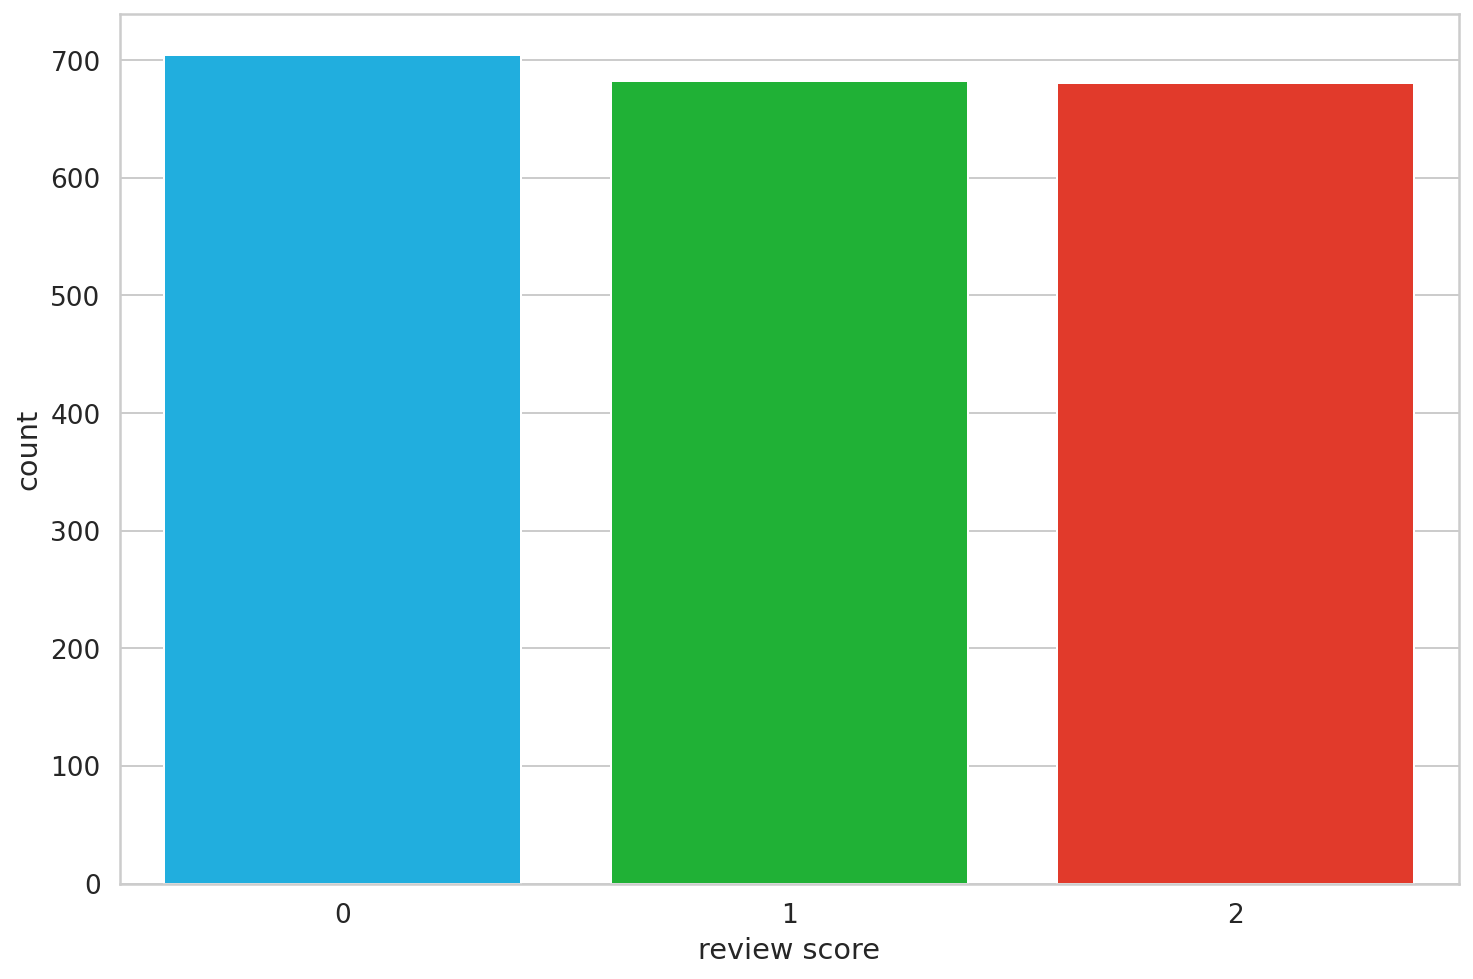

In [ ]:
sns.countplot(df.sentimento)
plt.xlabel('review score'); # 0-> positivo | 1-> neutro | 2-> negativo

In [ ]:
class_names = ['neutro', 'positivo', 'negativo']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


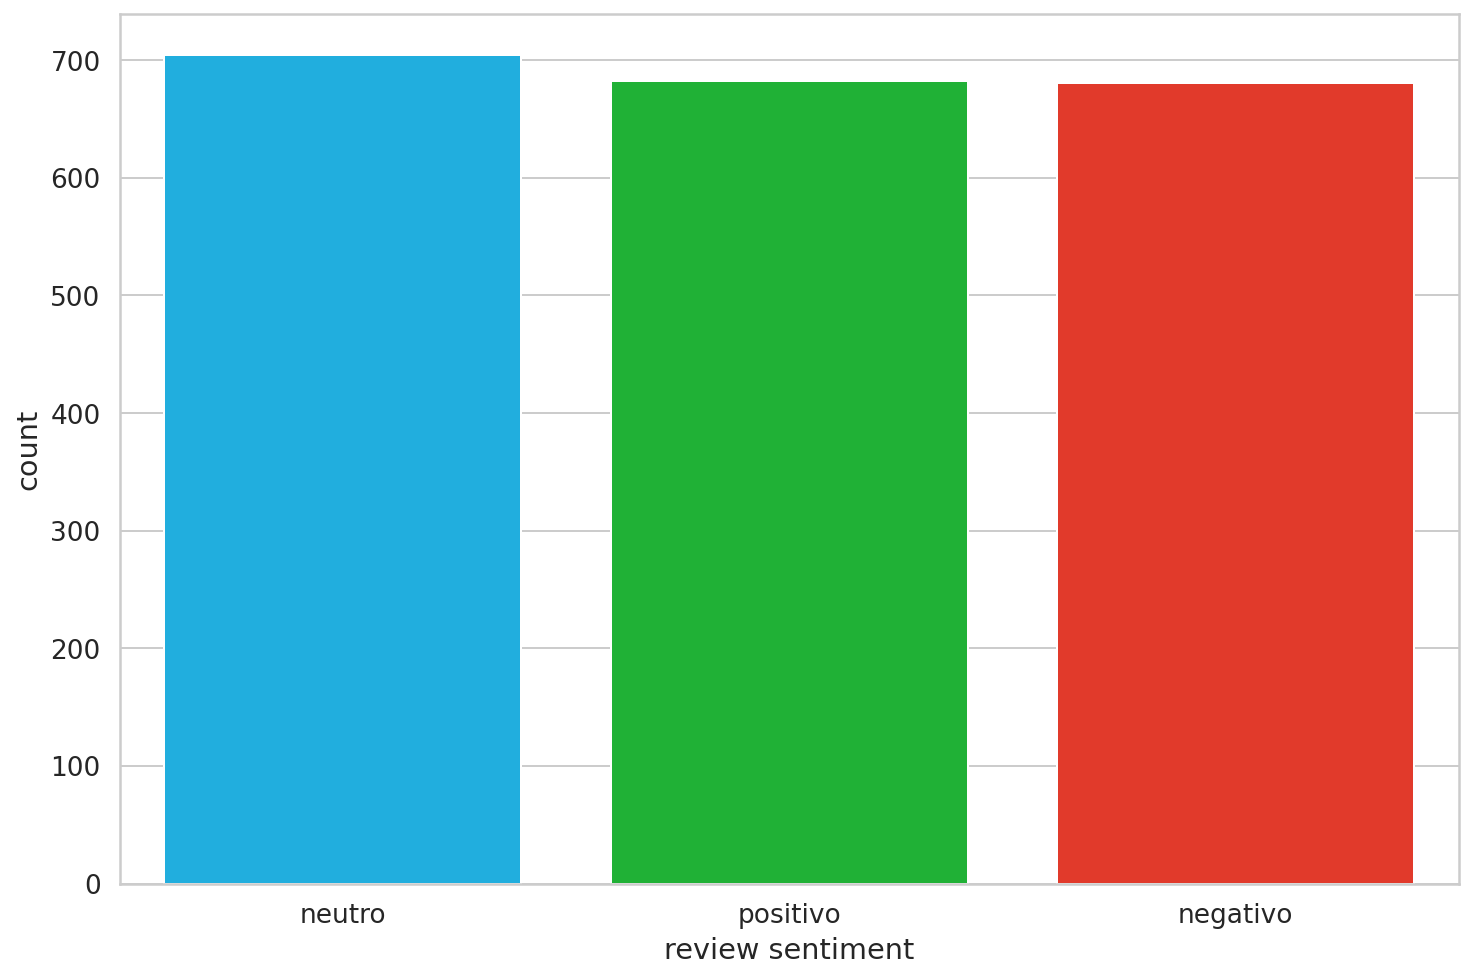

In [ ]:
ax = sns.countplot(df.sentimento)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

### Special Tokens

`[SEP]` `[CLS]` `[PAD]`


In [ ]:
sample_txt = 'Aguardando anciosamente pela vacina contra covid-19'

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101, 19316,   214,  7889,  6044,   246,   412, 13348,   387,   598,
          144,  1222,   118,   275,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = [] 

for txt in df.texto: 
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


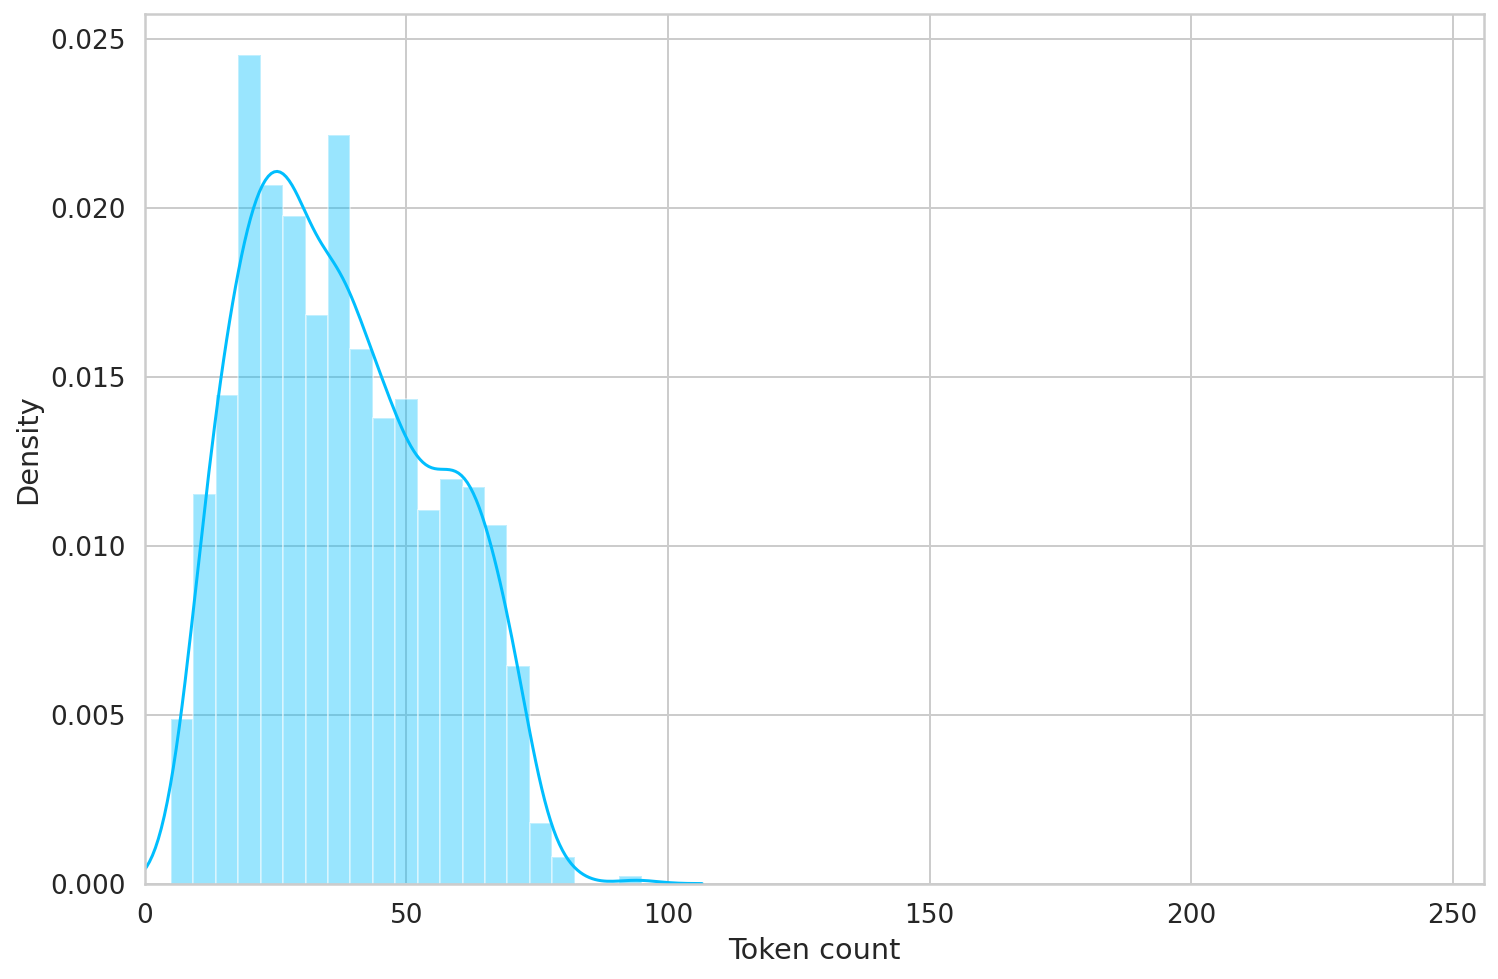

In [ ]:
#mostra o tamanho dos tweets em tokens
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 150

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
#divide os dados em treinamento, validação e teste -> 70 - 10 - 20
#df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED) #tamanho da base TESTE&VALIDAÇÃO em relação ao total da base
#df_val, df_test = train_test_split(df_test, test_size=0.66, random_state=RANDOM_SEED) #tamanho do base teste em relação a ao total da base TESTE&VALIDAÇÃO

#divide os dados em treinamento, validação e teste -> 80 - 10 - 10
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED) #tamanho da base TESTE&VALIDAÇÃO em relação ao total da base
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED) #tamanho do base teste em relação a ao total da base TESTE&VALIDAÇÃO

In [ ]:
#quantidade para cada amostra
df_train.shape, df_val.shape, df_test.shape

((1652, 5), (207, 5), (207, 5))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.texto.to_numpy(),
    targets=df.sentimento.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3224, 0.2980, 0.3796],
        [0.3992, 0.2869, 0.3139],
        [0.4166, 0.2706, 0.3128],
        [0.3743, 0.2753, 0.3504],
        [0.3618, 0.3089, 0.3293],
        [0.3077, 0.2803, 0.4120],
        [0.4088, 0.2793, 0.3119],
        [0.3283, 0.2790, 0.3928],
        [0.4286, 0.2443, 0.3271],
        [0.4610, 0.2503, 0.2886],
        [0.3441, 0.3101, 0.3459],
        [0.3681, 0.3492, 0.2827],
        [0.2439, 0.3059, 0.4502],
        [0.3920, 0.2710, 0.3370],
        [0.3611, 0.3012, 0.3376],
        [0.4311, 0.2858, 0.2831]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  #métricas
  y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
  print(classification_report(y_test, y_pred, target_names=class_names))

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss 0.7345377908876309 accuracy 0.6719128329297821
Val   loss 0.3939930670536481 accuracy 0.859903381642512

              precision    recall  f1-score   support

      neutro       0.83      0.70      0.76        70
    positivo       0.86      0.88      0.87        69
    negativo       0.83      0.94      0.88        68

    accuracy                           0.84       207
   macro avg       0.84      0.84      0.84       207
weighted avg       0.84      0.84      0.84       207

Epoch 2/4
----------
Train loss 0.25439723232725203 accuracy 0.9073849878934626
Val   loss 0.3712576126249937 accuracy 0.8792270531400965

              precision    recall  f1-score   support

      neutro       0.77      0.77      0.77        70
    positivo       0.88      0.86      0.87        69
    negativo       0.83      0.85      0.84        68

    accuracy                           0.83       207
   macro avg       0.83      0.83      0.83       207
weighted avg       0.83      0.83     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

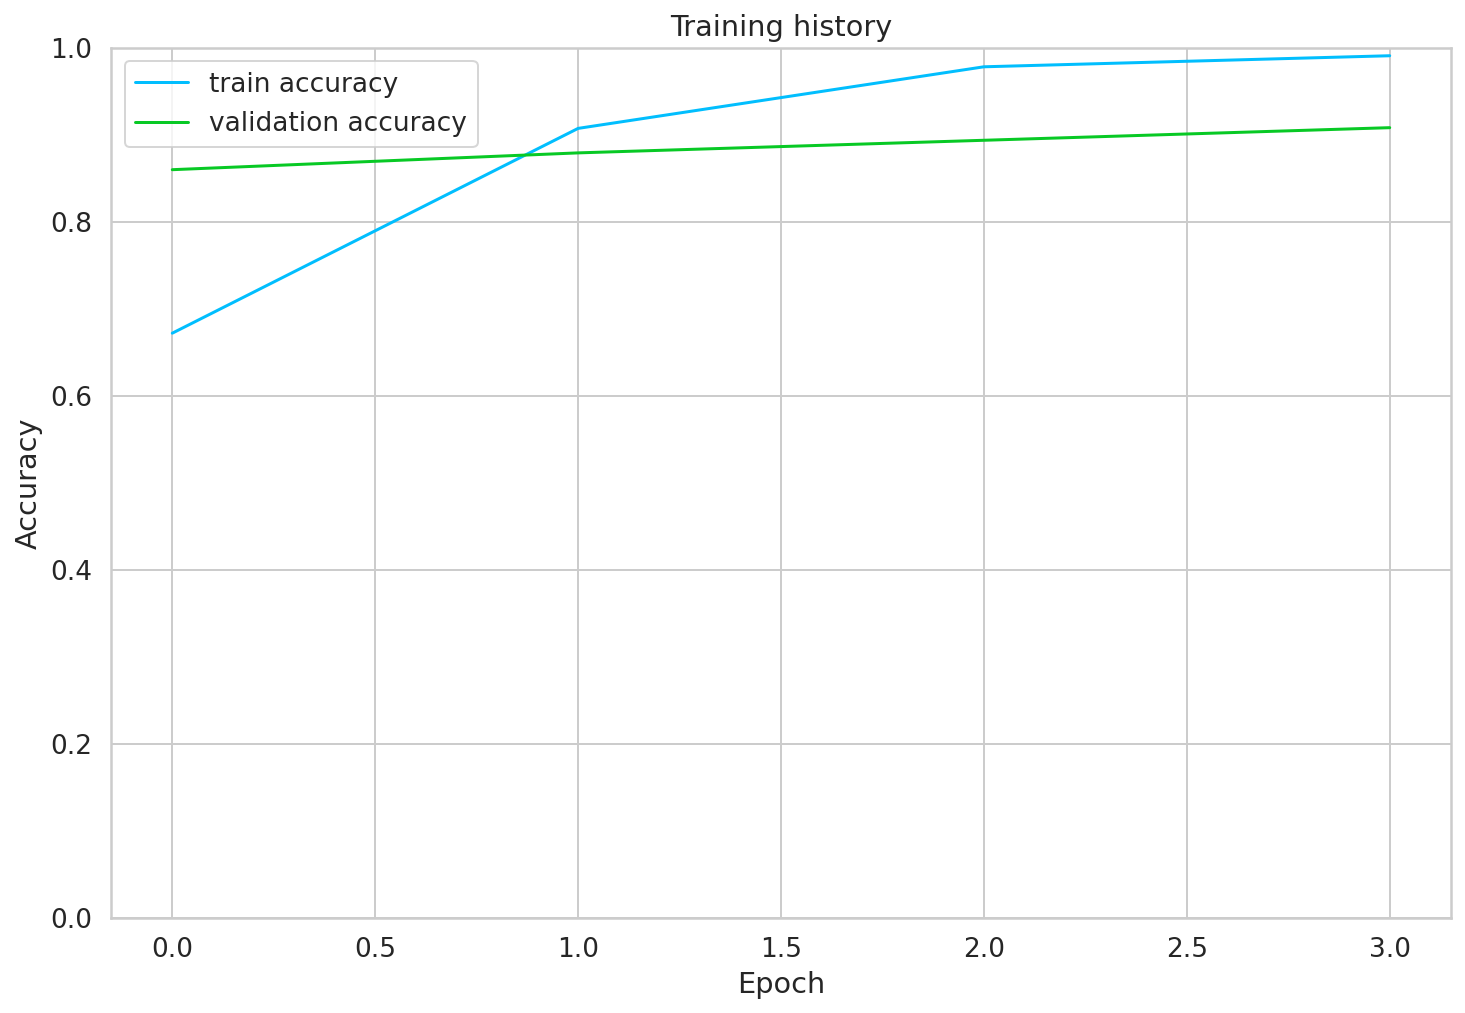

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8550724637681159

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      neutro       0.82      0.76      0.79        70
    positivo       0.85      0.91      0.88        69
    negativo       0.90      0.90      0.90        68

    accuracy                           0.86       207
   macro avg       0.85      0.86      0.85       207
weighted avg       0.85      0.86      0.85       207



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

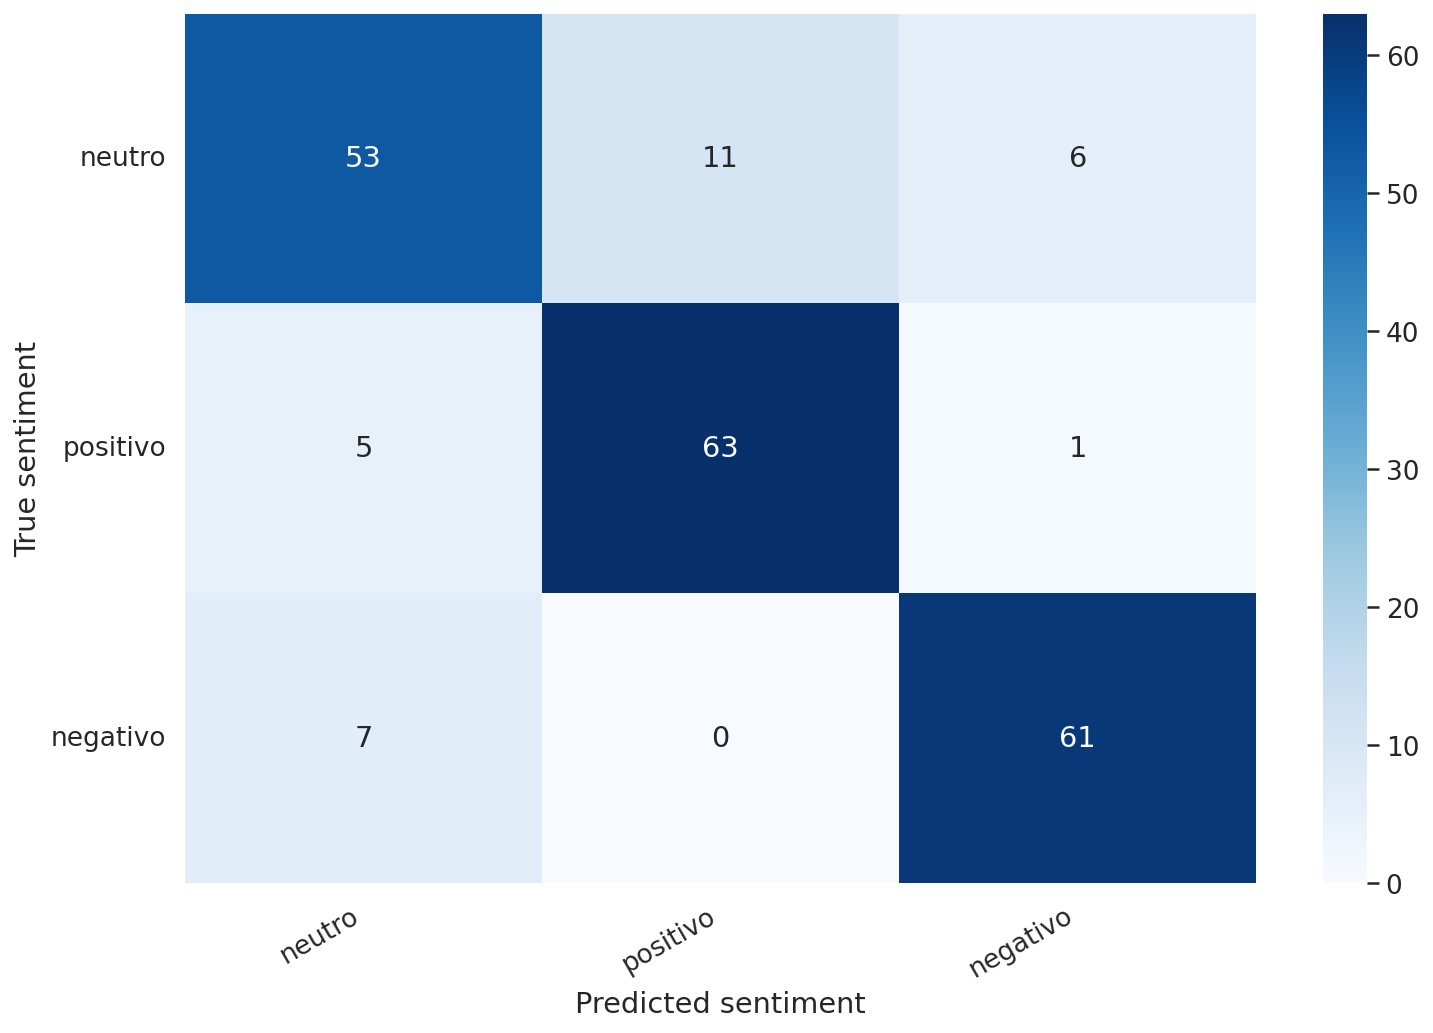

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
linha = 4

review_text = y_review_texts[linha]
true_sentiment = y_test[linha]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[linha]
})

tenho que explicar bem ne p que tu é meio lesa mas sim estou na
torcida que chegue logo mais vacinas pra continuar a vacinação

Sentimento da frase: positivo


Probabilidade para cada sentimento nesta frase:


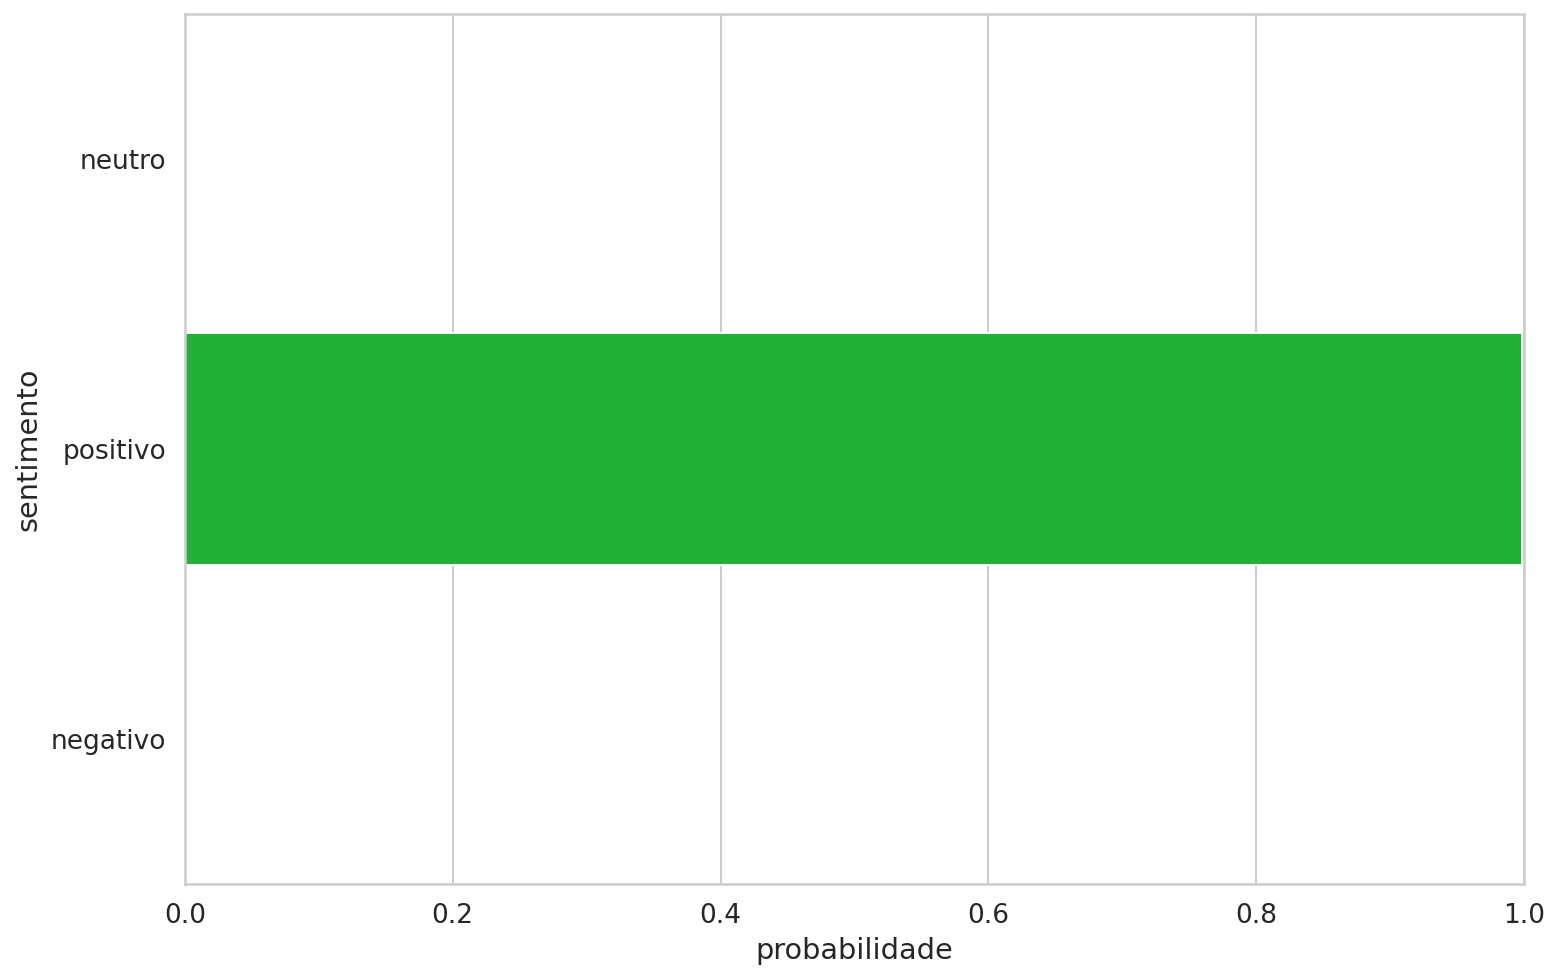

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'Sentimento da frase: {class_names[true_sentiment]}')

print()
print()
print("Probabilidade para cada sentimento nesta frase:")
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentimento')
plt.xlabel('probabilidade')
plt.xlim([0, 1]);

Now we can look at the confidence of each sentiment of our model:

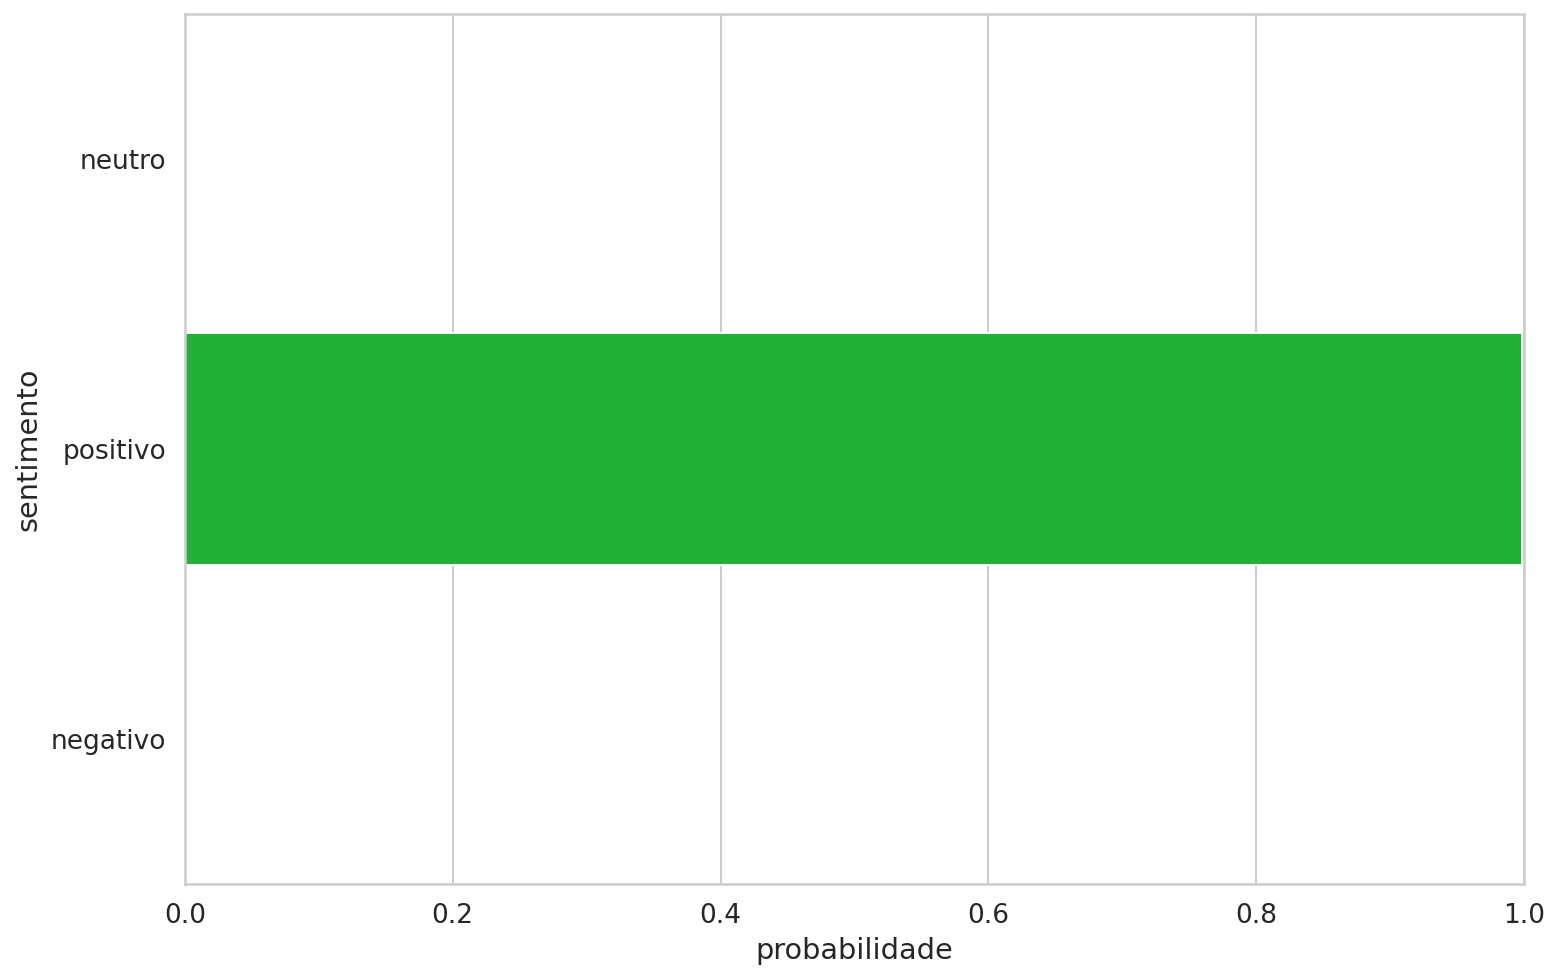

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentimento')
plt.xlabel('probabilidade')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = 'A vacinação aqui em caetité ta nos 28 anos. Daqui a pouco chega minha vez graçasadeus'
#review_text = 'Chega! A miséria é evidente! Não há emprego, garantia de vacinação em massa, tampouco vislumbre de um cenário favorável nos próximos meses. Precisamos garantir cuidados humanitários.'
#review_text = 'Não vou tomar mesmo essa vacina da china'
#review_text = 'Mas amiga, a vacina não funciona assim '
#review_text = 'Essa vacina tem uma doença que vai te matar daqui a dez anos'
#review_text = 'Só acho engraçado quem toma essa vacina'
#review_text = '['Vacina para todos'

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Frase: {review_text}')
print(f'Sentimento: {class_names[prediction]}')

Frase: A vacinação aqui em caetité ta nos 28 anos. Daqui a pouco chega minha vez graçasadeus
Sentimento: neutro


## **Classificar a base coletada**

In [ ]:
%%time
df_cla = pd.read_csv("/content/drive/MyDrive/All_Tweets_Final_5.csv", sep=";") # importar amostra para classificar automaticamente
df_cla.drop(['Unnamed: 0'], axis = 1, inplace=True)



clas_auto = []
for indice, linha in df_cla.iterrows():
  #tokeniza
  review_text = linha['full_text']
  encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)
  
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  clas_auto.append(class_names[prediction])

df_cla['class_auto'] = clas_auto


from google.colab import files
df_cla.to_csv('All_Tweets_Final_5.csv',  sep=";") 
files.download('All_Tweets_Final_5.csv')

In [ ]:
%%time
df_cla = pd.read_csv("/content/drive/MyDrive/All_Tweets_Final_7.csv", sep=";") # importar amostra para classificar automaticamente
df_cla.drop(['Unnamed: 0'], axis = 1, inplace=True)



clas_auto = []
for indice, linha in df_cla.iterrows():
  #tokeniza
  review_text = linha['full_text']
  encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)
  
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  clas_auto.append(class_names[prediction])

df_cla['class_auto'] = clas_auto


from google.colab import files
df_cla.to_csv('All_Tweets_Final_7.csv',  sep=";") 
files.download('All_Tweets_Final_7.csv')

In [ ]:
%%time
df_cla = pd.read_csv("/content/drive/MyDrive/All_Tweets_Final_10.csv", sep=";") # importar amostra para classificar automaticamente
df_cla.drop(['Unnamed: 0'], axis = 1, inplace=True)



clas_auto = []
for indice, linha in df_cla.iterrows():
  #tokeniza
  review_text = linha['full_text']
  encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)
  
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  clas_auto.append(class_names[prediction])

df_cla['class_auto'] = clas_auto


from google.colab import files
df_cla.to_csv('All_Tweets_Final_10.csv',  sep=";") 
files.download('All_Tweets_Final_10.csv')

In [ ]:
%%time
df_cla = pd.read_csv("/content/drive/MyDrive/All_Tweets_Final_1.csv", sep=";") # importar amostra para classificar automaticamente
df_cla.drop(['Unnamed: 0'], axis = 1, inplace=True)



clas_auto = []
for indice, linha in df_cla.iterrows():
  #tokeniza
  review_text = linha['full_text']
  encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)
  
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  clas_auto.append(class_names[prediction])

df_cla['class_auto'] = clas_auto


from google.colab import files
df_cla.to_csv('All_Tweets_Final_1.csv',  sep=";") 
files.download('All_Tweets_Final_1.csv')

In [ ]:
%%time
df_cla = pd.read_csv("/content/drive/MyDrive/All_Tweets_Final.csv", sep=";") # importar amostra para classificar automaticamente
df_cla.drop(['Unnamed: 0'], axis = 1, inplace=True)



clas_auto = []
for indice, linha in df_cla.iterrows():
  #tokeniza
  review_text = linha['full_text']
  encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)
  
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  clas_auto.append(class_names[prediction])

df_cla['class_auto'] = clas_auto


from google.colab import files
df_cla.to_csv('All_Tweets_Final.csv',  sep=";") 
files.download('All_Tweets_Final.csv')

In [ ]:
df_cla

In [ ]:
df_cla.drop(['Unnamed: 0'], axis = 1, inplace=True)

##**Analisar os tweets classificados**

In [ ]:
df_cla['data'] = pd.to_datetime(df_cla['data']).apply(lambda x: x.date())

In [ ]:
start_date =  pd.to_datetime("2021-08-01").date()
end_date = pd.to_datetime("2021-08-06").date()

after_start_date = df_cla['data'] >= start_date
before_end_date = df_cla['data'] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = df_cla.loc[between_two_dates]

In [ ]:
filtered_dates